In [17]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import umap
from tqdm import tqdm

from utils import prepare_data
from build_model import Autoencoder_5_Layers
from train_model import train_autoencoder

## Build the Autoencoder Model

Two models were built based on the Optuna trials and previous hyperaprameter optimisation, to be comapred in term of the resoulting cluster silhouette scores.

* Model_1 is based on Optuna
* Model_2 is based on previous hyperparameter optimisation

In [ ]:
# device agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"

# Prepare the data
DNA_meth_train = prepare_data("../Data/DNAMethylation_train.csv")
DNA_meth_test = prepare_data("../Data/DNAMethylation_test.csv")
RNA_seq_train = prepare_data("../Data/RNAseq_train.csv")
RNA_seq_test = prepare_data("../Data/RNAseq_test.csv")

# Merge
X_train = pd.merge(DNA_meth_train, RNA_seq_train, left_index=True, right_index=True)
X_test = pd.merge(DNA_meth_test, RNA_seq_test, left_index=True, right_index=True)

# Convert to tensors and send to device
X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32).to(device)
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32).to(device)

# Optuna hyperparameters
hidden_features_optuna = 143
epochs_optuna = 200

# Train the model based on Optuna hyperparameters
model = Autoencoder_5_Layers(input_features=X_train.shape[1], hidden_features=hidden_features_optuna)
model, train_loss, test_loss = train_autoencoder(model=model, 
                                                   loss_fn=nn.L1Loss(), 
                                                   optimizer=torch.optim.RMSprop(model.parameters(), lr=0.00001), 
                                                   epochs=epochs_optuna, 
                                                   X_train=X_train, X_test=X_test, 
                                                   updates=False)

# Save Autoencoder
torch.save(model.state_dict(), "trained_autoencoder.pt")

## Clustering

In [22]:
# Prepare Data
dna_methylation = prepare_data("../Data/DNAMethylation.csv", transpose=True, normalise=True)
rna_seq = prepare_data("../Data/RNAseq.csv", transpose=True, normalise=True)
data = pd.merge(dna_methylation, rna_seq, left_index=True, right_index=True)

# encode data
tensor_data = torch.tensor(data.to_numpy(), dtype=torch.float32).to(device) 
model.eval()
with torch.inference_mode():
    encoded_data = model.encode(tensor_data)

# convert to dataframe
encoded_dataframe = pd.DataFrame(encoded_data)

# k-means 
kmeans = KMeans(n_clusters=2, n_init='auto')
cluster_labels = kmeans.fit_predict(encoded_dataframe)
silhouette = silhouette_score(encoded_dataframe, cluster_labels)

# Print results
print(f"Silhouette Score: {silhouette}")

Silhouette Score: 0.5633434057235718


## Clustering Visualisation

### UMAP

/Users/frankpolak/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


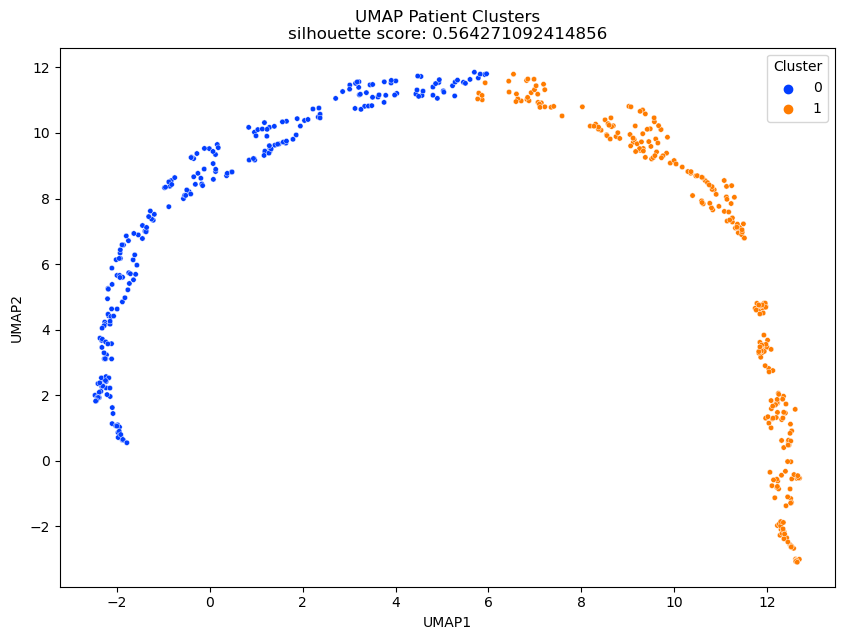

In [13]:
### UMAP - Visualisation

scaler = MinMaxScaler()
encoded_dataframe_s = scaler.fit_transform(encoded_dataframe)

umap_2d = umap.UMAP(n_components=2, random_state=42)
df_2d = umap_2d.fit_transform(encoded_dataframe_s) 

# Convert reduced data to a new DataFrame
df_umap = pd.DataFrame(df_2d, columns=["UMAP1", "UMAP2"])
df_umap["Cluster"] = cluster_labels

# Plot UMAP with cluster colors
plt.figure(figsize=(10, 7))
sns.scatterplot(x=df_umap["UMAP1"], y=df_umap["UMAP2"], hue=df_umap["Cluster"], palette="bright", s=15)
plt.title(f"UMAP Patient Clusters\nsilhouette score: {silhouette}")
plt.legend(title="Cluster")
plt.show()

/Users/frankpolak/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


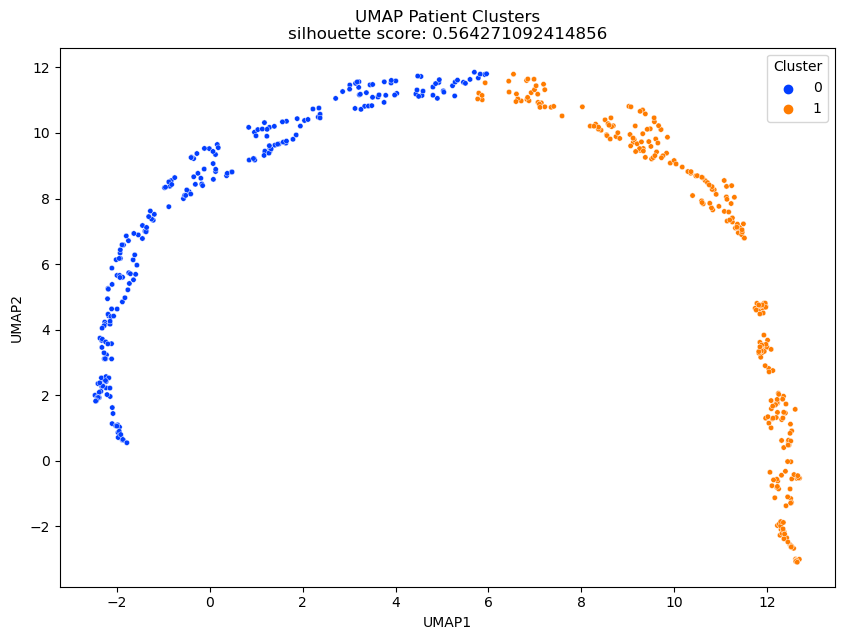

In [14]:
from sklearn.preprocessing import MinMaxScaler
import umap
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(encoded_dataframe)

# Apply UMAP on scaled data
umap_2d = umap.UMAP(n_components=2, random_state=42)
df_2d = umap_2d.fit_transform(scaled_data)

# Convert reduced data to a new DataFrame
df_umap = pd.DataFrame(df_2d, columns=["UMAP1", "UMAP2"])
df_umap["Cluster"] = cluster_labels

# Plot UMAP with cluster colors
plt.figure(figsize=(10, 7))
sns.scatterplot(x=df_umap["UMAP1"], y=df_umap["UMAP2"], hue=df_umap["Cluster"], palette="bright", s=15)
plt.title(f"UMAP Patient Clusters\nsilhouette score: {silhouette}")
plt.legend(title="Cluster")
plt.show()


### t-SNE

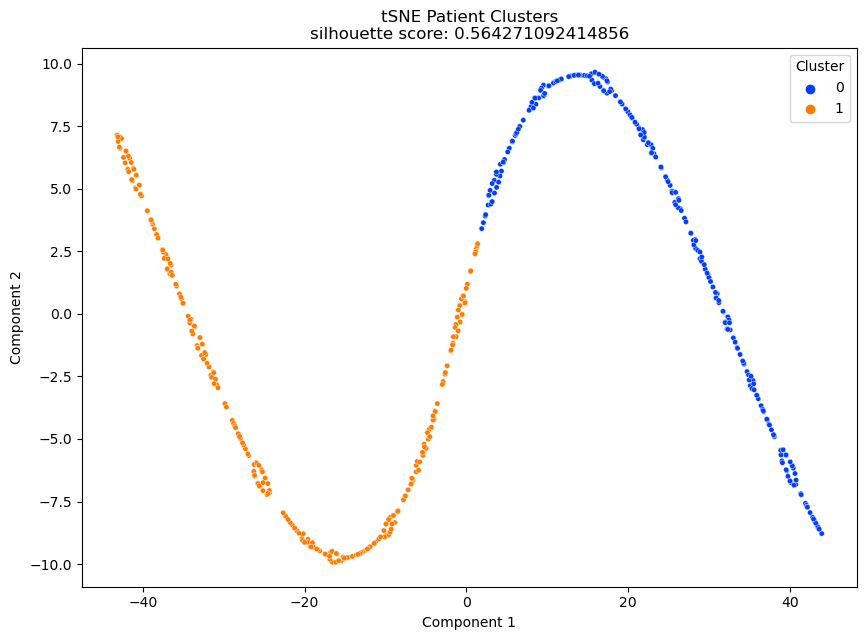

In [15]:
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(encoded_dataframe)

# Convert reduced data to a new DataFrame
df_umap = pd.DataFrame(X_embedded, columns=["Component 1", "Component 2"])
df_umap["Cluster"] = cluster_labels

# Plot UMAP with cluster colors
plt.figure(figsize=(10, 7))
sns.scatterplot(x=df_umap["Component 1"], y=df_umap["Component 2"], hue=df_umap["Cluster"], palette="bright", s=15)
plt.title(f"tSNE Patient Clusters\nsilhouette score: {silhouette}")
plt.legend(title="Cluster")
plt.show()

In [16]:
# Save clustered data
encoded_dataframe['cluster'] = cluster_labels
encoded_dataframe.to_csv('../Data/encoded_dataframe_with_clusters.csv', index=False)

## eXplainable AI


In [ ]:
# Required imports
import shap

# Ensure model is trained and in eval mode
model.eval()

# Prepare data (ensure tensors, already done in your notebook)
background_data = X_train.to(device)
explained_data = X_test.to(device)

# Function to extract latent space representation
def encode_only(x):
    with torch.no_grad():
        return model.encode(x)

# ========================
# SHAP with DeepExplainer 
# ========================
try:
    print("Trying DeepExplainer...")
    
    # Initialize with full model
    explainer = shap.DeepExplainer(model, background_data[:50])

    # Override model call to focus on encoder
    explainer.model = encode_only

    # Compute SHAP values
    shap_values = explainer.shap_values(explained_data[:10])
    
    print("DeepExplainer succeeded.")

except Exception as e:
    print(f"DeepExplainer failed: {e}")
    print("Falling back to KernelExplainer (slower)...")

    # ==============================
    # SHAP with KernelExplainer (slower but robust)
    # ==============================

    def encode_func(x_numpy):
        x_tensor = torch.tensor(x_numpy, dtype=torch.float32).to(device)
        with torch.no_grad():
            return model.encode(x_tensor).cpu().numpy()

    explainer = shap.KernelExplainer(encode_func, background_data[:100].cpu().numpy())
    shap_values = explainer.shap_values(explained_data[:50].cpu().numpy())

# ==============================
# Analyze SHAP Results
# ==============================

# Convert to NumPy array (latent_dim, num_samples, num_features)
shap_values = np.array(shap_values)

# Mean absolute SHAP per input feature
mean_abs_shap = np.abs(shap_values).mean(axis=(0, 1))

# Rank features
feature_ranking = np.argsort(mean_abs_shap)[::-1]

# Display top 10 most impactful features
print("\nTop 10 important input features:")
for idx in feature_ranking[:10]:
    print(f"Feature {idx} - Mean SHAP: {mean_abs_shap[idx]:.5f}")

# Optional: SHAP summary plot
shap.summary_plot(shap_values, explained_data[:50].cpu().numpy(), feature_names=X_test.columns.tolist())


Trying DeepExplainer...
